## Importing req libraries and load dataset and datloader

In [2]:
#import require libraries
import torch
from torch import nn
import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
# from collections import OrderedDict

In [3]:
!pip install -q torchmetrics
from torchmetrics.classification import MulticlassAccuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 8.0 MB/s eta 0:00:00


In [4]:
# write device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
# get and set dataset
train_data = CIFAR10(root = 'data', train = True, 
                     transform = ToTensor(), download = True)

test_data = CIFAR10(root = 'data', train = False,
                    transform = ToTensor(), download = True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [6]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(50000, 50000, 10000, 10000)

In [7]:
train_data.data[0].shape 

(32, 32, 3)

In [8]:
# fit dataset in 32 batch size dataloader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE,
                             shuffle = True)

print(f"total {len(train_dataloader)} train data loader of each {BATCH_SIZE} batch size")
print(f"total {len(test_dataloader)} test data loader of each {BATCH_SIZE} batch size")

total 1563 train data loader of each 32 batch size
total 313 test data loader of each 32 batch size


In [9]:
# class name
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [10]:
# give index to class
class_idx = train_data.class_to_idx
class_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

## Visulize data

image shape: torch.Size([3, 32, 32])


<ipython-input-11-f8c7d57eaa78>:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  plt.imshow(image.T.squeeze())


Text(0.5, 1.0, 'frog')

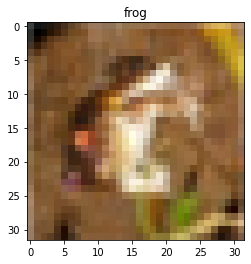

In [11]:
image, label = train_data[0]
print(f"image shape: {image.shape}")
plt.imshow(image.T.squeeze())
plt.title(class_names[label])

In [12]:
# look the size and shape of dataloader
train_feature_batch, train_label_batch = next(iter(train_dataloader))
train_feature_batch.shape, train_label_batch.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

In [13]:
len(train_feature_batch)

32

Text(0.5, 1.0, 'cat')

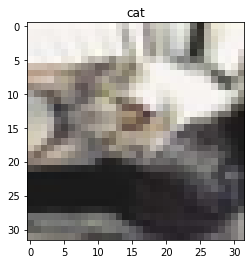

In [14]:
# image from dataloader
torch.manual_seed(64)

random_idx = torch.randint(0, len(train_feature_batch), size = [1]).item()
image, label = train_feature_batch[random_idx], train_label_batch[random_idx]
plt.imshow(image.T.squeeze())
plt.title(class_names[label])

# building model

In [15]:
transforms = transforms.Grayscale()

In [16]:
# here we have 3 channel images so first we need to transforms the image
flatten = nn.Flatten()

# transforms = transforms.Grayscale()

x = transforms(train_feature_batch[0])

out_flatten = flatten(x)

print(f"Shape of x: {x.shape}")
print(f"Shape of output of flatten: {out_flatten.shape}")

Shape of x: torch.Size([1, 32, 32])
Shape of output of flatten: torch.Size([1, 1024])


### sigmoid as activation function

In [17]:
# build base model
class CIFARSigModelV1(nn.Module):
  def __init__(self, input_units: int, hidden_units: int, output_units: int, num_hidden_layer: int):
    super().__init__()

    layers = [nn.Flatten()]

    for i in range(num_hidden_layer):
      if i == 0:
        # layers[str(i)] = nn.Sigmoid(nn.Linear(in_features = input_units, out_features = hidden_units))
        print(f"--------------i: {i} -------------")
        layers.append(nn.Linear(in_features = input_units, out_features = hidden_units))
        layers.append(nn.Sigmoid())

      # elif i == num_hidden_layer:
      #   # layers[str(i)] = nn.Sigmoid(nn.Linear(in_features = hidden_units, out_features = output_units))
      #   layers.append(nn.Linear(in_features = hidden_units, out_features = output_units))
      #   layers.append(nn.Sigmoid())

      else:
        # layers[str(i)] = nn.Sigmoid(nn.Linear(in_features = hidden_units, out_features = hidden_units))
        print(f"--------------i: {i} -------------")
        layers.append(nn.Linear(in_features = hidden_units, out_features = hidden_units))
        layers.append(nn.Sigmoid())
      # i += 1
      # layers[str(i)] = nn.Sigmoid()
    layers.append(nn.Linear(in_features = hidden_units, out_features = output_units))
    layers.append(nn.Sigmoid())
    self.layer = nn.Sequential(*layers)# with single hidden layer

  def forward(self, x):
    return self.layer(x)

# sig_model_0 = CIFARSigModelV1(input_units = 1024, hidden_units = 10,
#                               output_units = len(class_names), num_hidden_layer = 1).to(device)
# sig_model_0

In [18]:
# initial_params = sig_model_0.state_dict()
# w1_old = initial_params['layer.1.weight'].detach().clone()
# w1_old

## Loss and Accuracy Function

In [19]:
# loss and accuracy
loss_fn = nn.CrossEntropyLoss()

accuracy_fn = MulticlassAccuracy(num_classes = len(class_names)).to(device)

## Train and Test Loop

In [20]:
# train loop
def train_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer,
               accuracy_fn, device: torch.device = device):
  
  train_loss, train_acc = 0, 0

  for batch, (x_train, y_train) in enumerate(dataloader):

    if device == 'cuda':
      x_train, y_train = x_train.to(device), y_train.to(device) 

    # train
    model.train()

    # 1.Forward
    x_train = transforms(x_train)
    y_pred = model(x_train)

    # print(f"\ny_pred: {y_pred.shape} y_train:{y_train.shape}\n{torch.argmax(y_pred, dim = 1)}\n")
    # 2. Loss and accuracy
    loss = loss_fn(y_pred, y_train)
    train_loss += loss
    acc = accuracy_fn(y_train, torch.argmax(y_pred, dim = 1))
    train_acc += acc

    # 3. zero grad
    optimizer.zero_grad()

    # 4. backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  print(f"Train Loss: {train_loss:.4f} Train Accuracy: {train_acc:.4f}")

  return train_loss

In [21]:
# test loop
def test_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, accuracy_fn, device: torch.device = device):
  
  test_loss, test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for x_test, y_test in dataloader:

      if device == 'cuda':
        x_test, y_test = x_test.to(device), y_test.to(device) 

      x_test = transforms(x_test)

      # 1. Forward
      test_pred = model(x_test)

      # 2. Loss and Accuracy
      test_loss += loss_fn(test_pred, y_test)

      test_acc += accuracy_fn(y_test, torch.argmax(test_pred, dim = 1))

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")

  return test_loss

## Build model with 1 hidden layer

In [22]:
sig_model_0 = CIFARSigModelV1(input_units = 1024, hidden_units = 10,
                              output_units = len(class_names), num_hidden_layer = 1).to(device)
print(f"Model Structure:\n{sig_model_0}\n")

optimizer = torch.optim.SGD(params = sig_model_0.parameters(), lr = 0.2) # optimizer function

initial_params = sig_model_0.state_dict()
w1_old_m0 = initial_params['layer.1.weight'].detach().clone()
print(f"First Layer initial weights:\n{w1_old_m0}\n")

# train model
epoches = 5

torch.manual_seed(64)
torch.cuda.manual_seed(64)

for epoch in tqdm(range(epoches)):

  print(f"Epoch: {epoch+1} --------------------------")

  train_loss = train_loop(model = sig_model_0, dataloader = train_dataloader,
                          loss_fn = loss_fn, optimizer = optimizer,
                          accuracy_fn = accuracy_fn, device = device)
  
  test_loss = test_loop(model = sig_model_0, dataloader = test_dataloader,
                        loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                        device = device)
  
  print("\n")

post_params = sig_model_0.state_dict()
w1_new_m0 = post_params['layer.1.weight'].detach().clone()
print(f"Fisrt Layer weight after model train:\n{w1_new_m0}\n")

print(f"Weight change:\n{(w1_new_m0) - (w1_old_m0)}\n")

--------------i: 0 -------------
Model Structure:
CIFARSigModelV1(
  (layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=10, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Sigmoid()
  )
)

First Layer initial weights:
tensor([[ 0.0062, -0.0202, -0.0148,  ...,  0.0036,  0.0121, -0.0067],
        [-0.0019, -0.0043,  0.0040,  ..., -0.0214, -0.0208, -0.0232],
        [-0.0280, -0.0026,  0.0195,  ..., -0.0240, -0.0134,  0.0082],
        ...,
        [-0.0216, -0.0076, -0.0073,  ...,  0.0302,  0.0172,  0.0166],
        [ 0.0183, -0.0034, -0.0140,  ..., -0.0270,  0.0056,  0.0163],
        [ 0.0231, -0.0092, -0.0264,  ..., -0.0065, -0.0186, -0.0310]])



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 --------------------------
Train Loss: 2.2494 Train Accuracy: 0.0891
Test Loss: 2.2099 Test Accuracy: 0.1187


Epoch: 2 --------------------------
Train Loss: 2.1916 Train Accuracy: 0.1710
Test Loss: 2.1777 Test Accuracy: 0.1940


Epoch: 3 --------------------------
Train Loss: 2.1664 Train Accuracy: 0.2038
Test Loss: 2.1589 Test Accuracy: 0.2130


Epoch: 4 --------------------------
Train Loss: 2.1504 Train Accuracy: 0.2113
Test Loss: 2.1445 Test Accuracy: 0.2176


Epoch: 5 --------------------------
Train Loss: 2.1393 Train Accuracy: 0.2204
Test Loss: 2.1353 Test Accuracy: 0.2318


Fisrt Layer weight after model train:
tensor([[ 0.1047,  0.0666,  0.0739,  ...,  0.2105,  0.2361,  0.2267],
        [-0.1094, -0.1027, -0.0852,  ..., -0.0438, -0.0599, -0.0780],
        [ 0.0466,  0.0670,  0.0946,  ...,  0.1976,  0.2260,  0.2595],
        ...,
        [-0.1184, -0.0870, -0.0796,  ..., -0.0675, -0.0934, -0.0992],
        [-0.0169, -0.0329, -0.0379,  ...,  0.0065,  0.0249,  0.0198],

In [23]:
# # train model
# from tqdm.auto import tqdm

# epoches = 5

# torch.manual_seed(64)
# torch.cuda.manual_seed(64)

# for epoch in tqdm(range(epoches)):

#   print(f"Epoch: {epoch+1} --------------------------")

#   train_loop(model = sig_model_0, dataloader = train_dataloader,
#              loss_fn = loss_fn, optimizer = optimizer,
#              accuracy_fn = accuracy_fn, device = device)
  
#   test_loop(model = sig_model_0, dataloader = test_dataloader,
#             loss_fn = loss_fn, accuracy_fn = accuracy_fn,
#             device = device)
  
#   print("\n")

In [24]:
# post_params = sig_model_0.state_dict()
# w1_new = post_params['layer.1.weight'].detach().clone()
# w1_new

In [25]:
# w1_old

In [26]:
# abs(w1_new) - abs(w1_old)

## Build model with 2 hidden layer

In [27]:
sig_model_1 = CIFARSigModelV1(input_units = 1024, hidden_units = 10,
                              output_units = len(class_names), num_hidden_layer = 2).to(device)
print(f"Model Structure:\n{sig_model_1}\n")

optimizer = torch.optim.SGD(params = sig_model_1.parameters(), lr = 0.2) # optimizer function

initial_params = sig_model_1.state_dict()
w1_old_m1 = initial_params['layer.1.weight'].detach().clone()
print(f"First Layer initial weights:\n{w1_old_m1}\n")

# train model
epoches = 5

torch.manual_seed(64)
torch.cuda.manual_seed(64)

for epoch in tqdm(range(epoches)):

  print(f"Epoch: {epoch+1} --------------------------")

  train_loss = train_loop(model = sig_model_1, dataloader = train_dataloader,
                          loss_fn = loss_fn, optimizer = optimizer,
                          accuracy_fn = accuracy_fn, device = device)
  
  tes_loss = test_loop(model = sig_model_1, dataloader = test_dataloader,
                       loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                       device = device)
  
  print("\n")

post_params = sig_model_1.state_dict()
w1_new_m1 = post_params['layer.1.weight'].detach().clone()
print(f"Fisrt Layer weight after model train:\n{w1_new_m1}\n")

print(f"Weight change:\n{(w1_new_m1) - (w1_old_m1)}\n")

--------------i: 0 -------------
--------------i: 1 -------------
Model Structure:
CIFARSigModelV1(
  (layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=10, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=10, out_features=10, bias=True)
    (6): Sigmoid()
  )
)

First Layer initial weights:
tensor([[ 5.7628e-03, -1.8462e-02, -7.4081e-05,  ..., -1.0392e-02,
         -2.4489e-02,  1.2264e-02],
        [ 1.4443e-02, -2.4571e-03,  8.1005e-03,  ...,  2.6462e-02,
          3.1149e-02,  5.4572e-03],
        [ 2.9226e-02,  1.0673e-02, -1.7613e-02,  ..., -2.7092e-03,
          1.0549e-02, -5.9652e-03],
        ...,
        [-3.3409e-03, -1.7325e-02,  1.3076e-02,  ...,  1.2476e-02,
          1.9935e-02,  2.5574e-02],
        [ 1.5933e-02,  1.6055e-02, -3.2626e-03,  ...,  1.1303e-02,
          3.0211e-02, -2.8240e-02],
        [ 1.8169e-02,  5.7125e-0

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 --------------------------
Train Loss: 2.3020 Train Accuracy: 0.0193
Test Loss: 2.2985 Test Accuracy: 0.0276


Epoch: 2 --------------------------
Train Loss: 2.2745 Train Accuracy: 0.0536
Test Loss: 2.2389 Test Accuracy: 0.0719


Epoch: 3 --------------------------
Train Loss: 2.2199 Train Accuracy: 0.0690
Test Loss: 2.2059 Test Accuracy: 0.0674


Epoch: 4 --------------------------
Train Loss: 2.2016 Train Accuracy: 0.0776
Test Loss: 2.1970 Test Accuracy: 0.0880


Epoch: 5 --------------------------
Train Loss: 2.1937 Train Accuracy: 0.0782
Test Loss: 2.1909 Test Accuracy: 0.0776


Fisrt Layer weight after model train:
tensor([[-3.6724e-02, -5.7726e-02, -3.6765e-02,  ..., -1.4450e-02,
         -3.1529e-02,  1.8535e-03],
        [ 9.0865e-02,  6.6074e-02,  6.9858e-02,  ...,  6.9228e-02,
          8.2017e-02,  6.2676e-02],
        [-2.9038e-03, -1.6081e-02, -4.1352e-02,  ..., -2.1549e-02,
         -1.1591e-02, -3.0083e-02],
        ...,
        [-5.5429e-02, -6.1306e-02, -2.50

## Build model with 3 hidden layer

In [28]:
sig_model_2 = CIFARSigModelV1(input_units = 1024, hidden_units = 10,
                              output_units = len(class_names), num_hidden_layer = 3).to(device)
print(f"Model Structure:\n{sig_model_2}\n")

optimizer = torch.optim.SGD(params = sig_model_2.parameters(), lr = 0.2) # optimizer function

initial_params = sig_model_2.state_dict()
w1_old_m2 = initial_params['layer.1.weight'].detach().clone()
print(f"First Layer initial weights:\n{w1_old_m2}\n")

# train model
epoches = 5

torch.manual_seed(64)
torch.cuda.manual_seed(64)

for epoch in tqdm(range(epoches)):

  print(f"Epoch: {epoch+1} --------------------------")

  train_loss = train_loop(model = sig_model_2, dataloader = train_dataloader,
                          loss_fn = loss_fn, optimizer = optimizer,
                          accuracy_fn = accuracy_fn, device = device)
  
  test_loss = test_loop(model = sig_model_2, dataloader = test_dataloader,
                        loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                        device = device)
  
  print("\n")

post_params = sig_model_2.state_dict()
w1_new_m2 = post_params['layer.1.weight'].detach().clone()
print(f"Fisrt Layer weight after model train:\n{w1_new_m2}\n")

print(f"Weight change:\n{(w1_new_m2) - (w1_old_m2)}\n")

--------------i: 0 -------------
--------------i: 1 -------------
--------------i: 2 -------------
Model Structure:
CIFARSigModelV1(
  (layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=10, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=10, out_features=10, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=10, out_features=10, bias=True)
    (8): Sigmoid()
  )
)

First Layer initial weights:
tensor([[ 5.7628e-03, -1.8462e-02, -7.4081e-05,  ..., -1.0392e-02,
         -2.4489e-02,  1.2264e-02],
        [ 1.4443e-02, -2.4571e-03,  8.1005e-03,  ...,  2.6462e-02,
          3.1149e-02,  5.4572e-03],
        [ 2.9226e-02,  1.0673e-02, -1.7613e-02,  ..., -2.7092e-03,
          1.0549e-02, -5.9652e-03],
        ...,
        [-3.3409e-03, -1.7325e-02,  1.3076e-02,  ...,  1.2476e-02,
          1.9935e-02,  2.5574e-02],
        [ 1.5933e-02,  

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 --------------------------
Train Loss: 2.3033 Train Accuracy: 0.0100
Test Loss: 2.3028 Test Accuracy: 0.0100


Epoch: 2 --------------------------
Train Loss: 2.3030 Train Accuracy: 0.0101
Test Loss: 2.3028 Test Accuracy: 0.0100


Epoch: 3 --------------------------
Train Loss: 2.3030 Train Accuracy: 0.0104
Test Loss: 2.3027 Test Accuracy: 0.0100


Epoch: 4 --------------------------
Train Loss: 2.3029 Train Accuracy: 0.0106
Test Loss: 2.3028 Test Accuracy: 0.0100


Epoch: 5 --------------------------
Train Loss: 2.3029 Train Accuracy: 0.0114
Test Loss: 2.3024 Test Accuracy: 0.0100


Fisrt Layer weight after model train:
tensor([[ 0.0083, -0.0159,  0.0025,  ..., -0.0098, -0.0240,  0.0127],
        [ 0.0325,  0.0152,  0.0258,  ...,  0.0256,  0.0310,  0.0060],
        [ 0.0317,  0.0129, -0.0154,  ..., -0.0020,  0.0116, -0.0044],
        ...,
        [-0.0017, -0.0158,  0.0146,  ...,  0.0105,  0.0180,  0.0238],
        [ 0.0050,  0.0051, -0.0143,  ...,  0.0127,  0.0311, -0.0277],

## Build model with 4 hidden layer

In [29]:
sig_model_3 = CIFARSigModelV1(input_units = 1024, hidden_units = 10,
                              output_units = len(class_names), num_hidden_layer = 4).to(device)
print(f"Model Structure:\n{sig_model_3}\n")

optimizer = torch.optim.SGD(params = sig_model_3.parameters(), lr = 0.2) # optimizer function

initial_params = sig_model_3.state_dict()
w1_old_m3 = initial_params['layer.1.weight'].detach().clone()
print(f"First Layer initial weights:\n{w1_old_m3}\n")

# train model
epoches = 5

torch.manual_seed(64)
torch.cuda.manual_seed(64)

for epoch in tqdm(range(epoches)):

  print(f"Epoch: {epoch+1} --------------------------")

  train_loss = train_loop(model = sig_model_3, dataloader = train_dataloader,
                          loss_fn = loss_fn, optimizer = optimizer,
                          accuracy_fn = accuracy_fn, device = device)
  
  test_loss = test_loop(model = sig_model_3, dataloader = test_dataloader,
                        loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                        device = device)
  
  print("\n")

post_params = sig_model_3.state_dict()
w1_new_m3 = post_params['layer.1.weight'].detach().clone()
print(f"Fisrt Layer weight after model train:\n{w1_new_m3}\n")

print(f"Weight change:\n{(w1_new_m3) - (w1_old_m3)}\n")

--------------i: 0 -------------
--------------i: 1 -------------
--------------i: 2 -------------
--------------i: 3 -------------
Model Structure:
CIFARSigModelV1(
  (layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=10, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=10, out_features=10, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=10, out_features=10, bias=True)
    (8): Sigmoid()
    (9): Linear(in_features=10, out_features=10, bias=True)
    (10): Sigmoid()
  )
)

First Layer initial weights:
tensor([[ 5.7628e-03, -1.8462e-02, -7.4081e-05,  ..., -1.0392e-02,
         -2.4489e-02,  1.2264e-02],
        [ 1.4443e-02, -2.4571e-03,  8.1005e-03,  ...,  2.6462e-02,
          3.1149e-02,  5.4572e-03],
        [ 2.9226e-02,  1.0673e-02, -1.7613e-02,  ..., -2.7092e-03,
          1.0549e-02, -5.9652e-03],
        ...,
        [-3.3

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 --------------------------
Train Loss: 2.3031 Train Accuracy: 0.0099
Test Loss: 2.3028 Test Accuracy: 0.0100


Epoch: 2 --------------------------
Train Loss: 2.3030 Train Accuracy: 0.0098
Test Loss: 2.3028 Test Accuracy: 0.0100


Epoch: 3 --------------------------
Train Loss: 2.3030 Train Accuracy: 0.0099
Test Loss: 2.3027 Test Accuracy: 0.0100


Epoch: 4 --------------------------
Train Loss: 2.3029 Train Accuracy: 0.0101
Test Loss: 2.3029 Test Accuracy: 0.0100


Epoch: 5 --------------------------
Train Loss: 2.3030 Train Accuracy: 0.0099
Test Loss: 2.3027 Test Accuracy: 0.0100


Fisrt Layer weight after model train:
tensor([[ 0.0070, -0.0173,  0.0011,  ..., -0.0100, -0.0241,  0.0127],
        [ 0.0147, -0.0022,  0.0083,  ...,  0.0275,  0.0323,  0.0066],
        [ 0.0297,  0.0112, -0.0171,  ..., -0.0032,  0.0101, -0.0065],
        ...,
        [-0.0032, -0.0172,  0.0132,  ...,  0.0118,  0.0192,  0.0248],
        [ 0.0163,  0.0165, -0.0028,  ...,  0.0111,  0.0300, -0.0285],

# Building model as Tanh an Activation function

In [30]:
class CIFARTanhModel(nn.Module):
  def __init__(self, input_units: int, hidden_units: int, output_units: int, number_hidden_layers: int):
    super().__init__()

    layers = []

    for i in range(number_hidden_layers):
      if i == 0:
        layers.append(nn.Flatten())
        layers.append(nn.Linear(in_features = input_units, out_features = hidden_units))
        layers.append(nn.Tanh())

      else:
        layers.append(nn.Linear(in_features = hidden_units, out_features = hidden_units))
        layers.append(nn.Tanh())

    layers.append(nn.Linear(in_features = hidden_units, out_features = output_units))
    layers.append(nn.Tanh())

    self.layer = nn.Sequential(*layers)

  def forward(self, x):
    return self.layer(x)

Loss, Accuracy, train loop, test loop are already implemented before 
so no need to re create them simple we re use them

## Build model with 1 hidden layer

In [31]:
# torch.manual_seed(64)
# tanh_model_1 = CIFARTanhModel(input_units = 1024, hidden_units = 10,
#                               output_units = len(class_names), number_hidden_layers = 1).to(device)
# print(f"Model Structue:\n{tanh_model_1}\n")


# optimizer = torch.optim.SGD(params = tanh_model_1.parameters(), lr = 0.1)   # optimizer

# initial_weight = tanh_model_1.state_dict()
# w1_old_tm1 = initial_weight['layer.1.weight'].detach().clone()
# print(f"Initial First layer weights:\n{w1_old_tm1}\n")

# # train model
# torch.manual_seed(64)
# epoches = 5

# for epoch in tqdm(range(epoches)):
#   print(f"epoch: {epoch+1} ------------------------")

#   train_loop(model = tanh_model_1, dataloader = train_dataloader,
#              loss_fn = loss_fn, optimizer = optimizer,
#              accuracy_fn = accuracy_fn, device = device)
  
#   test_loop(model = tanh_model_1, dataloader = test_dataloader,
#             loss_fn = loss_fn, accuracy_fn = accuracy_fn,
#             device= device)
  
#   print("\n")

# final_weight = tanh_model_1.state_dict()
# w1_new_tm1 = final_weight['layer.1.weight'].detach().clone()
# print(f"Final First layer weight:\n{w1_new_tm1}\n")

# print(f"Change in weight:\n{(w1_new_tm1) - (w1_old_tm1)}")

## Build model with 2 hidden layer

In [32]:
# torch.manual_seed(64)
# tanh_model_2 = CIFARTanhModel(input_units = 1024, hidden_units = 10,
#                               output_units = len(class_names), number_hidden_layers = 2).to(device)
# print(f"Model Structue:\n{tanh_model_2}\n")


# optimizer = torch.optim.SGD(params = tanh_model_2.parameters(), lr = 0.1)   # optimizer

# initial_weight = tanh_model_2.state_dict()
# w1_old_tm2 = initial_weight['layer.1.weight'].detach().clone()
# print(f"Initial First layer weights:\n{w1_old_tm2}\n")

# # train model
# torch.manual_seed(64)
# epoches = 5

# for epoch in tqdm(range(epoches)):
#   print(f"epoch: {epoch+1} ------------------------")

#   train_loop(model = tanh_model_2, dataloader = train_dataloader,
#              loss_fn = loss_fn, optimizer = optimizer,
#              accuracy_fn = accuracy_fn, device = device)
  
#   test_loop(model = tanh_model_2, dataloader = test_dataloader,
#             loss_fn = loss_fn, accuracy_fn = accuracy_fn,
#             device= device)
  
#   print("\n")

# final_weight = tanh_model_2.state_dict()
# w1_new_tm2 = final_weight['layer.1.weight'].detach().clone()
# print(f"Final First layer weight:\n{w1_new_tm2}\n")

# print(f"Change in weight:\n{(w1_new_tm2) - (w1_old_tm2)}")

## Build model with 3 hidden layer

In [33]:
# torch.manual_seed(64)
# tanh_model_3 = CIFARTanhModel(input_units = 1024, hidden_units = 10,
#                               output_units = len(class_names), number_hidden_layers = 3).to(device)
# print(f"Model Structue:\n{tanh_model_3}\n")


# optimizer = torch.optim.SGD(params = tanh_model_3.parameters(), lr = 0.1)   # optimizer

# initial_weight = tanh_model_3.state_dict()
# w1_old_tm3 = initial_weight['layer.1.weight'].detach().clone()
# print(f"Initial First layer weights:\n{w1_old_tm3}\n")

# # train model
# torch.manual_seed(64)
# epoches = 5

# for epoch in tqdm(range(epoches)):
#   print(f"epoch: {epoch+1} ------------------------")

#   train_loop(model = tanh_model_3, dataloader = train_dataloader,
#              loss_fn = loss_fn, optimizer = optimizer,
#              accuracy_fn = accuracy_fn, device = device)
  
#   test_loop(model = tanh_model_3, dataloader = test_dataloader,
#             loss_fn = loss_fn, accuracy_fn = accuracy_fn,
#             device= device)
  
#   print("\n")

# final_weight = tanh_model_3.state_dict()
# w1_new_tm3 = final_weight['layer.1.weight'].detach().clone()
# print(f"Final First layer weight:\n{w1_new_tm3}\n")

# print(f"Change in weight:\n{(w1_new_tm3) - (w1_old_tm3)}")

## Build model with 4 hidden layer

In [34]:
# torch.manual_seed(64)
# tanh_model_4 = CIFARTanhModel(input_units = 1024, hidden_units = 10,
#                               output_units = len(class_names), number_hidden_layers = 4).to(device)
# print(f"Model Structue:\n{tanh_model_4}\n")


# optimizer = torch.optim.SGD(params = tanh_model_4.parameters(), lr = 0.1)   # optimizer

# initial_weight = tanh_model_4.state_dict()
# w1_old_tm4 = initial_weight['layer.1.weight'].detach().clone()
# print(f"Initial First layer weights:\n{w1_old_tm4}\n")

# # train model
# torch.manual_seed(64)
# epoches = 5

# for epoch in tqdm(range(epoches)):
#   print(f"epoch: {epoch+1} ------------------------")

#   train_loop(model = tanh_model_4, dataloader = train_dataloader,
#              loss_fn = loss_fn, optimizer = optimizer,
#              accuracy_fn = accuracy_fn, device = device)
  
#   test_loop(model = tanh_model_4, dataloader = test_dataloader,
#             loss_fn = loss_fn, accuracy_fn = accuracy_fn,
#             device= device)
  
#   print("\n")

# final_weight = tanh_model_4.state_dict()
# w1_new_tm4 = final_weight['layer.1.weight'].detach().clone()
# print(f"Final First layer weight:\n{w1_new_tm4}\n")

# print(f"Change in weight:\n{(w1_new_tm4) - (w1_old_tm4)}")

## Build Model with differ ent hidden layer

In [35]:
torch.manual_seed(64)

for i in range(1, 11):
  print(f"\nModel with {i*2} hidden layer\n\n")
  tanh_model_1 = CIFARTanhModel(input_units = 1024, hidden_units = 10,
                                output_units = len(class_names), number_hidden_layers = i*2).to(device)
  print(f"Model Structue:\n{tanh_model_1}\n")


  optimizer = torch.optim.SGD(params = tanh_model_1.parameters(), lr = 0.2)   # optimizer

  initial_weight = tanh_model_1.state_dict()
  w1_old_tm1 = initial_weight['layer.1.weight'].detach().clone()
  print(f"Initial First layer weights:\n{w1_old_tm1}\n")

  # train model
  torch.manual_seed(64)
  epoches = 5

  prev_test_loss = 0
  for epoch in tqdm(range(epoches)):
    print(f"epoch: {epoch+1} ------------------------")

    train_loss = train_loop(model = tanh_model_1, dataloader = train_dataloader,
                            loss_fn = loss_fn, optimizer = optimizer,
                            accuracy_fn = accuracy_fn, device = device)
    
    if epoch != 0:
      prev_test_loss = test_loss

    test_loss = test_loop(model = tanh_model_1, dataloader = test_dataloader,
                          loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                          device= device)
    
    
    
    print("\n")

  final_weight = tanh_model_1.state_dict()
  w1_new_tm1 = final_weight['layer.1.weight'].detach().clone()
  print(f"Final First layer weight:\n{w1_new_tm1}\n")

  print(f"Change in weight:\n{(w1_new_tm1) - (w1_old_tm1)}")


  if abs(prev_test_loss - test_loss) <= 0.0005:
    break
  


Model with 2 hidden layer


Model Structue:
CIFARTanhModel(
  (layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=10, bias=True)
    (2): Tanh()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Tanh()
    (5): Linear(in_features=10, out_features=10, bias=True)
    (6): Tanh()
  )
)

Initial First layer weights:
tensor([[-0.0282,  0.0062, -0.0202,  ...,  0.0112,  0.0036,  0.0121],
        [-0.0067, -0.0019, -0.0043,  ...,  0.0072, -0.0214, -0.0208],
        [-0.0232, -0.0280, -0.0026,  ..., -0.0054, -0.0240, -0.0134],
        ...,
        [-0.0224, -0.0216, -0.0076,  ...,  0.0009,  0.0302,  0.0172],
        [ 0.0166,  0.0183, -0.0034,  ..., -0.0306, -0.0270,  0.0056],
        [ 0.0163,  0.0231, -0.0092,  ...,  0.0120, -0.0065, -0.0186]])



  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 1 ------------------------
Train Loss: 2.1227 Train Accuracy: 0.1712
Test Loss: 2.2909 Test Accuracy: 0.1450


epoch: 2 ------------------------
Train Loss: 2.0525 Train Accuracy: 0.2143
Test Loss: 2.0237 Test Accuracy: 0.2287


epoch: 3 ------------------------
Train Loss: 2.0292 Train Accuracy: 0.2286
Test Loss: 2.0376 Test Accuracy: 0.2112


epoch: 4 ------------------------
Train Loss: 2.0178 Train Accuracy: 0.2400
Test Loss: 2.0340 Test Accuracy: 0.2432


epoch: 5 ------------------------
Train Loss: 2.0115 Train Accuracy: 0.2466
Test Loss: 2.0249 Test Accuracy: 0.2440


Final First layer weight:
tensor([[-0.1089, -0.0423, -0.0282,  ...,  0.2012,  0.1882,  0.1974],
        [-0.0145, -0.0492, -0.0459,  ..., -0.1295, -0.2121, -0.2258],
        [-0.0605, -0.0607, -0.0272,  ...,  0.0502,  0.0427,  0.0583],
        ...,
        [ 0.2602,  0.1855,  0.1472,  ...,  0.0475,  0.1180,  0.1422],
        [ 0.2136,  0.2021,  0.1669,  ..., -0.2336, -0.2076, -0.1968],
        [-0.2615, -0.

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 1 ------------------------
Train Loss: 2.1600 Train Accuracy: 0.1360
Test Loss: 2.1648 Test Accuracy: 0.1540


epoch: 2 ------------------------
Train Loss: 2.0881 Train Accuracy: 0.1836
Test Loss: 2.0634 Test Accuracy: 0.2014


epoch: 3 ------------------------
Train Loss: 2.0582 Train Accuracy: 0.1945
Test Loss: 2.0935 Test Accuracy: 0.1977


epoch: 4 ------------------------
Train Loss: 2.0388 Train Accuracy: 0.2113
Test Loss: 2.0447 Test Accuracy: 0.1940


epoch: 5 ------------------------
Train Loss: 2.0295 Train Accuracy: 0.2233
Test Loss: 2.0239 Test Accuracy: 0.2291


Final First layer weight:
tensor([[ 0.3240,  0.2718,  0.2564,  ..., -0.1475, -0.1506, -0.0999],
        [ 0.2139,  0.1488,  0.1233,  ...,  0.0296,  0.0766,  0.0626],
        [-0.0256, -0.0228, -0.0560,  ..., -0.1543, -0.1473, -0.1649],
        ...,
        [-0.0307, -0.0437, -0.0393,  ..., -0.2056, -0.2049, -0.2010],
        [-0.1206, -0.0706, -0.0625,  ..., -0.0671, -0.0895, -0.1956],
        [ 0.0928,  0.

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 1 ------------------------
Train Loss: 2.1995 Train Accuracy: 0.0863
Test Loss: 2.2433 Test Accuracy: 0.0874


epoch: 2 ------------------------
Train Loss: 2.1193 Train Accuracy: 0.1586
Test Loss: 2.0893 Test Accuracy: 0.1609


epoch: 3 ------------------------
Train Loss: 2.0908 Train Accuracy: 0.1692
Test Loss: 2.0950 Test Accuracy: 0.1456


epoch: 4 ------------------------
Train Loss: 2.0741 Train Accuracy: 0.1839
Test Loss: 2.0534 Test Accuracy: 0.1920


epoch: 5 ------------------------
Train Loss: 2.0590 Train Accuracy: 0.1976
Test Loss: 2.1253 Test Accuracy: 0.1693


Final First layer weight:
tensor([[ 0.0954,  0.0641,  0.0779,  ...,  0.1024,  0.0928,  0.1292],
        [-0.1396, -0.1336, -0.1061,  ...,  0.2167,  0.2035,  0.1678],
        [-0.0935, -0.0718, -0.0773,  ...,  0.3132,  0.3183,  0.2763],
        ...,
        [ 0.0129, -0.0173,  0.0213,  ...,  0.0415,  0.0527,  0.0505],
        [ 0.1073,  0.0756,  0.0530,  ...,  0.2509,  0.3254,  0.2961],
        [ 0.0566,  0.

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 1 ------------------------
Train Loss: 2.2174 Train Accuracy: 0.0563
Test Loss: 2.3162 Test Accuracy: 0.0900


epoch: 2 ------------------------
Train Loss: 2.1465 Train Accuracy: 0.1215
Test Loss: 2.1105 Test Accuracy: 0.1346


epoch: 3 ------------------------
Train Loss: 2.1174 Train Accuracy: 0.1337
Test Loss: 2.1237 Test Accuracy: 0.0878


epoch: 4 ------------------------
Train Loss: 2.1076 Train Accuracy: 0.1420
Test Loss: 2.0850 Test Accuracy: 0.1643


epoch: 5 ------------------------
Train Loss: 2.0968 Train Accuracy: 0.1448
Test Loss: 2.1144 Test Accuracy: 0.1283


Final First layer weight:
tensor([[-0.0898, -0.1223, -0.0814,  ..., -0.0565, -0.1079, -0.0875],
        [ 0.0433,  0.0114,  0.0172,  ...,  0.0717,  0.0816,  0.0704],
        [ 0.0166,  0.0105, -0.0199,  ..., -0.1190, -0.0710, -0.0663],
        ...,
        [-0.0694, -0.0781, -0.0602,  ..., -0.1786, -0.1832, -0.1861],
        [ 0.1344,  0.1122,  0.0859,  ..., -0.0006,  0.0536,  0.0367],
        [-0.1139, -0.

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 1 ------------------------
Train Loss: 2.2746 Train Accuracy: 0.0270
Test Loss: 2.2269 Test Accuracy: 0.0634


epoch: 2 ------------------------
Train Loss: 2.1814 Train Accuracy: 0.0695
Test Loss: 2.1580 Test Accuracy: 0.0716


epoch: 3 ------------------------
Train Loss: 2.1613 Train Accuracy: 0.0784
Test Loss: 2.1417 Test Accuracy: 0.0527


epoch: 4 ------------------------
Train Loss: 2.1484 Train Accuracy: 0.0813
Test Loss: 2.3128 Test Accuracy: 0.0394


epoch: 5 ------------------------
Train Loss: 2.1375 Train Accuracy: 0.0754
Test Loss: 2.1473 Test Accuracy: 0.0574


Final First layer weight:
tensor([[ 0.0985,  0.0710,  0.0780,  ..., -0.0819, -0.0941, -0.0436],
        [ 0.1357,  0.1032,  0.1094,  ...,  0.0658,  0.0928,  0.0890],
        [-0.0611, -0.0845, -0.1192,  ..., -0.3007, -0.3077, -0.3551],
        ...,
        [-0.0887, -0.0946, -0.0641,  ..., -0.0899, -0.0997, -0.1045],
        [-0.0337, -0.0312, -0.0380,  ..., -0.0189, -0.0086, -0.0668],
        [ 0.0198, -0.

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 1 ------------------------
Train Loss: 2.3047 Train Accuracy: 0.0101
Test Loss: 2.3067 Test Accuracy: 0.0100


epoch: 2 ------------------------
Train Loss: 2.3046 Train Accuracy: 0.0107
Test Loss: 2.3011 Test Accuracy: 0.0366


epoch: 3 ------------------------
Train Loss: 2.2111 Train Accuracy: 0.0507
Test Loss: 2.1926 Test Accuracy: 0.0483


epoch: 4 ------------------------
Train Loss: 2.1751 Train Accuracy: 0.0642
Test Loss: 2.1559 Test Accuracy: 0.0633


epoch: 5 ------------------------
Train Loss: 2.1527 Train Accuracy: 0.0717
Test Loss: 2.1585 Test Accuracy: 0.0856


Final First layer weight:
tensor([[-0.0527, -0.0658, -0.0412,  ..., -0.0352, -0.0577, -0.0254],
        [ 0.0098, -0.0136, -0.0069,  ...,  0.0480,  0.0543,  0.0359],
        [ 0.1468,  0.1146,  0.0660,  ...,  0.1519,  0.1829,  0.1943],
        ...,
        [ 0.0627,  0.0371,  0.0554,  ...,  0.0708,  0.0829,  0.0910],
        [ 0.1094,  0.0853,  0.0547,  ...,  0.0795,  0.1214,  0.0703],
        [ 0.0450,  0.

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 1 ------------------------
Train Loss: 2.3047 Train Accuracy: 0.0099
Test Loss: 2.3060 Test Accuracy: 0.0100


epoch: 2 ------------------------
Train Loss: 2.3048 Train Accuracy: 0.0100
Test Loss: 2.3041 Test Accuracy: 0.0100


epoch: 3 ------------------------
Train Loss: 2.3044 Train Accuracy: 0.0100
Test Loss: 2.3038 Test Accuracy: 0.0100


epoch: 4 ------------------------
Train Loss: 2.3044 Train Accuracy: 0.0099
Test Loss: 2.3044 Test Accuracy: 0.0100


epoch: 5 ------------------------
Train Loss: 2.3043 Train Accuracy: 0.0098
Test Loss: 2.3040 Test Accuracy: 0.0100


Final First layer weight:
tensor([[ 0.0061, -0.0181,  0.0002,  ..., -0.0108, -0.0249,  0.0119],
        [ 0.0138, -0.0031,  0.0074,  ...,  0.0268,  0.0315,  0.0058],
        [ 0.0220,  0.0034, -0.0249,  ..., -0.0003,  0.0127, -0.0042],
        ...,
        [-0.0043, -0.0183,  0.0121,  ...,  0.0124,  0.0198,  0.0254],
        [ 0.0175,  0.0177, -0.0016,  ...,  0.0113,  0.0302, -0.0282],
        [ 0.0121, -0.

## Methods to overcome the vanishing gradient problem

### use ReLu as activation function

In [36]:
class CIFARReLUModel(nn.Module):
  def __init__(self, input_units: int, hidden_units: int, output_units: int, number_hidden_layers: int):
    super().__init__()

    layers = []

    for i in range(number_hidden_layers):
      if i == 0:
        layers.append(nn.Flatten())
        layers.append(nn.Linear(in_features = input_units, out_features = hidden_units))
        layers.append(nn.ReLU())

      else:
        layers.append(nn.Linear(in_features = hidden_units, out_features = hidden_units))
        layers.append(nn.ReLU())

    layers.append(nn.Linear(in_features = hidden_units, out_features = output_units))
    layers.append(nn.ReLU())

    self.layer = nn.Sequential(*layers)

  def forward(self, x):
    return self.layer(x)

In [42]:
torch.manual_seed(64)

for i in range(1, 11):
  print(f"\nModel with {i*2} hidden layer\n\n")
  relu_model_1 = CIFARReLUModel(input_units = 1024, hidden_units = 10,
                                output_units = len(class_names), number_hidden_layers = i*2).to(device)
  print(f"Model Structue:\n{relu_model_1}\n")


  optimizer = torch.optim.SGD(params = relu_model_1.parameters(), lr = 0.1)   # optimizer

  initial_weight = relu_model_1.state_dict()
  w1_old_tm1 = initial_weight['layer.1.weight'].detach().clone()
  print(f"Initial First layer weights:\n{w1_old_tm1}\n")

  # train model
  torch.manual_seed(64)
  epoches = 5

  prev_test_loss = 0
  for epoch in tqdm(range(epoches)):
    print(f"epoch: {epoch+1} ------------------------")

    train_loss = train_loop(model = relu_model_1, dataloader = train_dataloader,
                            loss_fn = loss_fn, optimizer = optimizer,
                            accuracy_fn = accuracy_fn, device = device)
    
    if epoch != 0:
      prev_test_loss = test_loss

    test_loss = test_loop(model = relu_model_1, dataloader = test_dataloader,
                          loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                          device= device)
    
    
    
    print("\n")

  final_weight = relu_model_1.state_dict()
  w1_new_tm1 = final_weight['layer.1.weight'].detach().clone()
  print(f"Final First layer weight:\n{w1_new_tm1}\n")

  print(f"Change in weight:\n{(w1_new_tm1) - (w1_old_tm1)}")


  if abs(prev_test_loss - test_loss) <= 0.0005:
    break
  


Model with 2 hidden layer


Model Structue:
CIFARReLUModel(
  (layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=10, bias=True)
    (6): ReLU()
  )
)

Initial First layer weights:
tensor([[-0.0282,  0.0062, -0.0202,  ...,  0.0112,  0.0036,  0.0121],
        [-0.0067, -0.0019, -0.0043,  ...,  0.0072, -0.0214, -0.0208],
        [-0.0232, -0.0280, -0.0026,  ..., -0.0054, -0.0240, -0.0134],
        ...,
        [-0.0224, -0.0216, -0.0076,  ...,  0.0009,  0.0302,  0.0172],
        [ 0.0166,  0.0183, -0.0034,  ..., -0.0306, -0.0270,  0.0056],
        [ 0.0163,  0.0231, -0.0092,  ...,  0.0120, -0.0065, -0.0186]])



  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 1 ------------------------
Train Loss: 2.1953 Train Accuracy: 0.1149
Test Loss: 2.5734 Test Accuracy: 0.0688


epoch: 2 ------------------------
Train Loss: 2.0865 Train Accuracy: 0.1980
Test Loss: 2.0509 Test Accuracy: 0.2435


epoch: 3 ------------------------
Train Loss: 2.0355 Train Accuracy: 0.2218
Test Loss: 2.0128 Test Accuracy: 0.2289


epoch: 4 ------------------------
Train Loss: 2.0281 Train Accuracy: 0.2295
Test Loss: 2.0409 Test Accuracy: 0.2197


epoch: 5 ------------------------
Train Loss: 2.0190 Train Accuracy: 0.2312
Test Loss: 2.0419 Test Accuracy: 0.2243


Final First layer weight:
tensor([[-0.0293,  0.0050, -0.0212,  ...,  0.0098,  0.0024,  0.0109],
        [ 0.0109,  0.0010,  0.0016,  ..., -0.0646, -0.1271, -0.1225],
        [-0.0239, -0.0287, -0.0032,  ..., -0.0070, -0.0254, -0.0147],
        ...,
        [ 0.1790,  0.1166,  0.0935,  ..., -0.0004,  0.0378,  0.0264],
        [ 0.0325,  0.0307,  0.0078,  ..., -0.0386, -0.0350,  0.0003],
        [ 0.1968,  0.

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 1 ------------------------
Train Loss: 2.2948 Train Accuracy: 0.0261
Test Loss: 2.2849 Test Accuracy: 0.0360


epoch: 2 ------------------------
Train Loss: 2.2816 Train Accuracy: 0.0365
Test Loss: 2.2679 Test Accuracy: 0.0429


epoch: 3 ------------------------
Train Loss: 2.2673 Train Accuracy: 0.0527
Test Loss: 2.2696 Test Accuracy: 0.0548


epoch: 4 ------------------------
Train Loss: 2.2655 Train Accuracy: 0.0474
Test Loss: 2.2639 Test Accuracy: 0.0503


epoch: 5 ------------------------
Train Loss: 2.2643 Train Accuracy: 0.0510
Test Loss: 2.2683 Test Accuracy: 0.0470


Final First layer weight:
tensor([[ 0.0028, -0.0208, -0.0030,  ...,  0.0244,  0.0083,  0.0445],
        [ 0.0158, -0.0032,  0.0065,  ...,  0.0288,  0.0341,  0.0100],
        [ 0.0285,  0.0099, -0.0183,  ..., -0.0029,  0.0103, -0.0061],
        ...,
        [ 0.0004, -0.0117,  0.0187,  ...,  0.0146,  0.0234,  0.0280],
        [ 0.0804,  0.0917,  0.0712,  ...,  0.0149,  0.0384, -0.0253],
        [ 0.0254,  0.

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 1 ------------------------
Train Loss: 2.2977 Train Accuracy: 0.0215
Test Loss: 2.2661 Test Accuracy: 0.0266


epoch: 2 ------------------------
Train Loss: 2.2457 Train Accuracy: 0.0483
Test Loss: 2.2527 Test Accuracy: 0.0867


epoch: 3 ------------------------
Train Loss: 2.2323 Train Accuracy: 0.0658
Test Loss: 2.2427 Test Accuracy: 0.0762


epoch: 4 ------------------------
Train Loss: 2.2269 Train Accuracy: 0.0783
Test Loss: 2.2326 Test Accuracy: 0.0960


epoch: 5 ------------------------
Train Loss: 2.2218 Train Accuracy: 0.0843
Test Loss: 2.2241 Test Accuracy: 0.0945


Final First layer weight:
tensor([[-0.0093, -0.0337, -0.0147,  ...,  0.0032, -0.0112,  0.0257],
        [ 0.1810,  0.1166,  0.0878,  ...,  0.0556,  0.0673,  0.0566],
        [ 0.0113, -0.0114, -0.0380,  ...,  0.0271,  0.0446,  0.0309],
        ...,
        [-0.0010, -0.0092,  0.0263,  ..., -0.0021,  0.0067,  0.0106],
        [ 0.0549,  0.0478,  0.0241,  ...,  0.0153,  0.0358, -0.0198],
        [ 0.0044,  0.

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 1 ------------------------
Train Loss: 2.3029 Train Accuracy: 0.0100
Test Loss: 2.3026 Test Accuracy: 0.0100


epoch: 2 ------------------------
Train Loss: 2.3026 Train Accuracy: 0.0100
Test Loss: 2.3026 Test Accuracy: 0.0100


epoch: 3 ------------------------
Train Loss: 2.3026 Train Accuracy: 0.0100
Test Loss: 2.3026 Test Accuracy: 0.0100


epoch: 4 ------------------------
Train Loss: 2.3026 Train Accuracy: 0.0100
Test Loss: 2.3026 Test Accuracy: 0.0100


epoch: 5 ------------------------
Train Loss: 2.3026 Train Accuracy: 0.0100
Test Loss: 2.3026 Test Accuracy: 0.0100


Final First layer weight:
tensor([[ 5.7901e-03, -1.8435e-02, -4.4634e-05,  ..., -1.0423e-02,
         -2.4521e-02,  1.2232e-02],
        [ 1.4369e-02, -2.5298e-03,  8.0264e-03,  ...,  2.6452e-02,
          3.1139e-02,  5.4456e-03],
        [ 2.9220e-02,  1.0667e-02, -1.7619e-02,  ..., -2.7213e-03,
          1.0539e-02, -5.9748e-03],
        ...,
        [-3.2687e-03, -1.7251e-02,  1.3151e-02,  ...,  1.2491e

### Hyper parameter Turning
- like learning rate (make it small but not too small)

- Reduce network layer or reduce layer nodes